In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/images.zip /content
!cp /content/drive/MyDrive/features.pickle /content
!cp /content/drive/MyDrive/filenames.pickle /content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip '/content/images.zip'

Archive:  /content/images.zip
   creating: images/Ainsworth_Dyer/
  inflating: images/Ainsworth_Dyer/Ainsworth_Dyer_0001.jpg  
   creating: images/Alex_Popov/
  inflating: images/Alex_Popov/Alex_Popov_0001.jpg  
   creating: images/Alexander_Payne/
  inflating: images/Alexander_Payne/Alexander_Payne_0001.jpg  
   creating: images/Alison_Lohman/
  inflating: images/Alison_Lohman/Alison_Lohman_0001.jpg  
  inflating: images/Alison_Lohman/Alison_Lohman_0002.jpg  
   creating: images/Amer_al-Saadi/
  inflating: images/Amer_al-Saadi/Amer_al-Saadi_0001.jpg  
  inflating: images/Amer_al-Saadi/Amer_al-Saadi_0002.jpg  
  inflating: images/Amer_al-Saadi/Amer_al-Saadi_0003.jpg  
  inflating: images/Amer_al-Saadi/Amer_al-Saadi_0004.jpg  
   creating: images/Andre_Smith/
  inflating: images/Andre_Smith/Andre_Smith_0001.jpg  
   creating: images/Angel_Maza/
  inflating: images/Angel_Maza/Angel_Maza_0001.jpg  
   creating: images/Angela_Lansbury/
  inflating: images/Angela_Lansbury/Angela_Lansbury_00

In [ ]:
filenames_path = '/content/filenames.pickle'
features_path = '/content/features.pickle'
images_folder_path = '/content/images'

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
import tensorflow
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm



extensions = ['.jpg']


def get_file_list(root_dir):
    file_list = []
    counter = 1

    for root, dirs, filenames in os.walk(root_dir):
        for filename in tqdm(filenames):
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return sorted(file_list)


def get_stored_features():
    stored_filenames = pickle.load(open(filenames_path, 'rb'))
    stored_feature_list = pickle.load(open(features_path, 'rb'))
    return stored_filenames, stored_feature_list


def visualize_features():
    filenames, features = get_stored_features()

    num_feature_dimensions = 100  # Set the number of features
    pca = PCA(n_components=num_feature_dimensions)
    pca.fit(features)
    feature_list_compressed = pca.transform(features)

    tsne = TSNE(n_components=2, verbose=1, n_iter=4000, metric='cosine', init='pca')
    tsne_results = tsne.fit_transform(feature_list_compressed)
    tsne_results = StandardScaler().fit_transform(tsne_results)

    size = (45, 45)
    imgs = [img_to_array(load_img(path, target_size=size)) / 255 for path in filenames]
    visualize_scatter_with_images(tsne_results, imgs=imgs, size=size, zoom=0.7)


def visualize_scatter_with_images(data, imgs, size=(28, 28), zoom=1):
    fig, ax = plt.subplots(figsize=size)
    artist = []
    for xy, i in tqdm(zip(data, imgs)):
        x, y = xy
        img = OffsetImage(i, zoom=zoom)
        ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
        artist.append(ax.add_artist(ab))
    ax.update_datalim(data)
    ax.autoscale()
    ax.axis('off')
    plt.tight_layout(pad=1.2)
    plt.show()


In [ ]:
import pickle

import numpy as np
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')


def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    f = model.predict(x)
    return f.flatten()


def extract_dataset_features():
    file_list = get_file_list(images_folder_path)
    feature_list = []

    for filename in tqdm(file_list):
        feature_list.append(extract_features(filename))

    return file_list, feature_list


def update_features():
    file_list, features = extract_dataset_features()

    pickle.dump(file_list, open(filenames_path, 'wb'))
    pickle.dump(features, open(features_path, 'wb'))

    return file_list, features


if __name__ == "__main__":
    update_features()

83697664/83683744 [==============================] - 0s 0us/step


0it [00:00, ?it/s]
100%|██████████| 241/241 [01:05<00:00,  3.68it/s]


0it [00:00, ?it/s]
100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


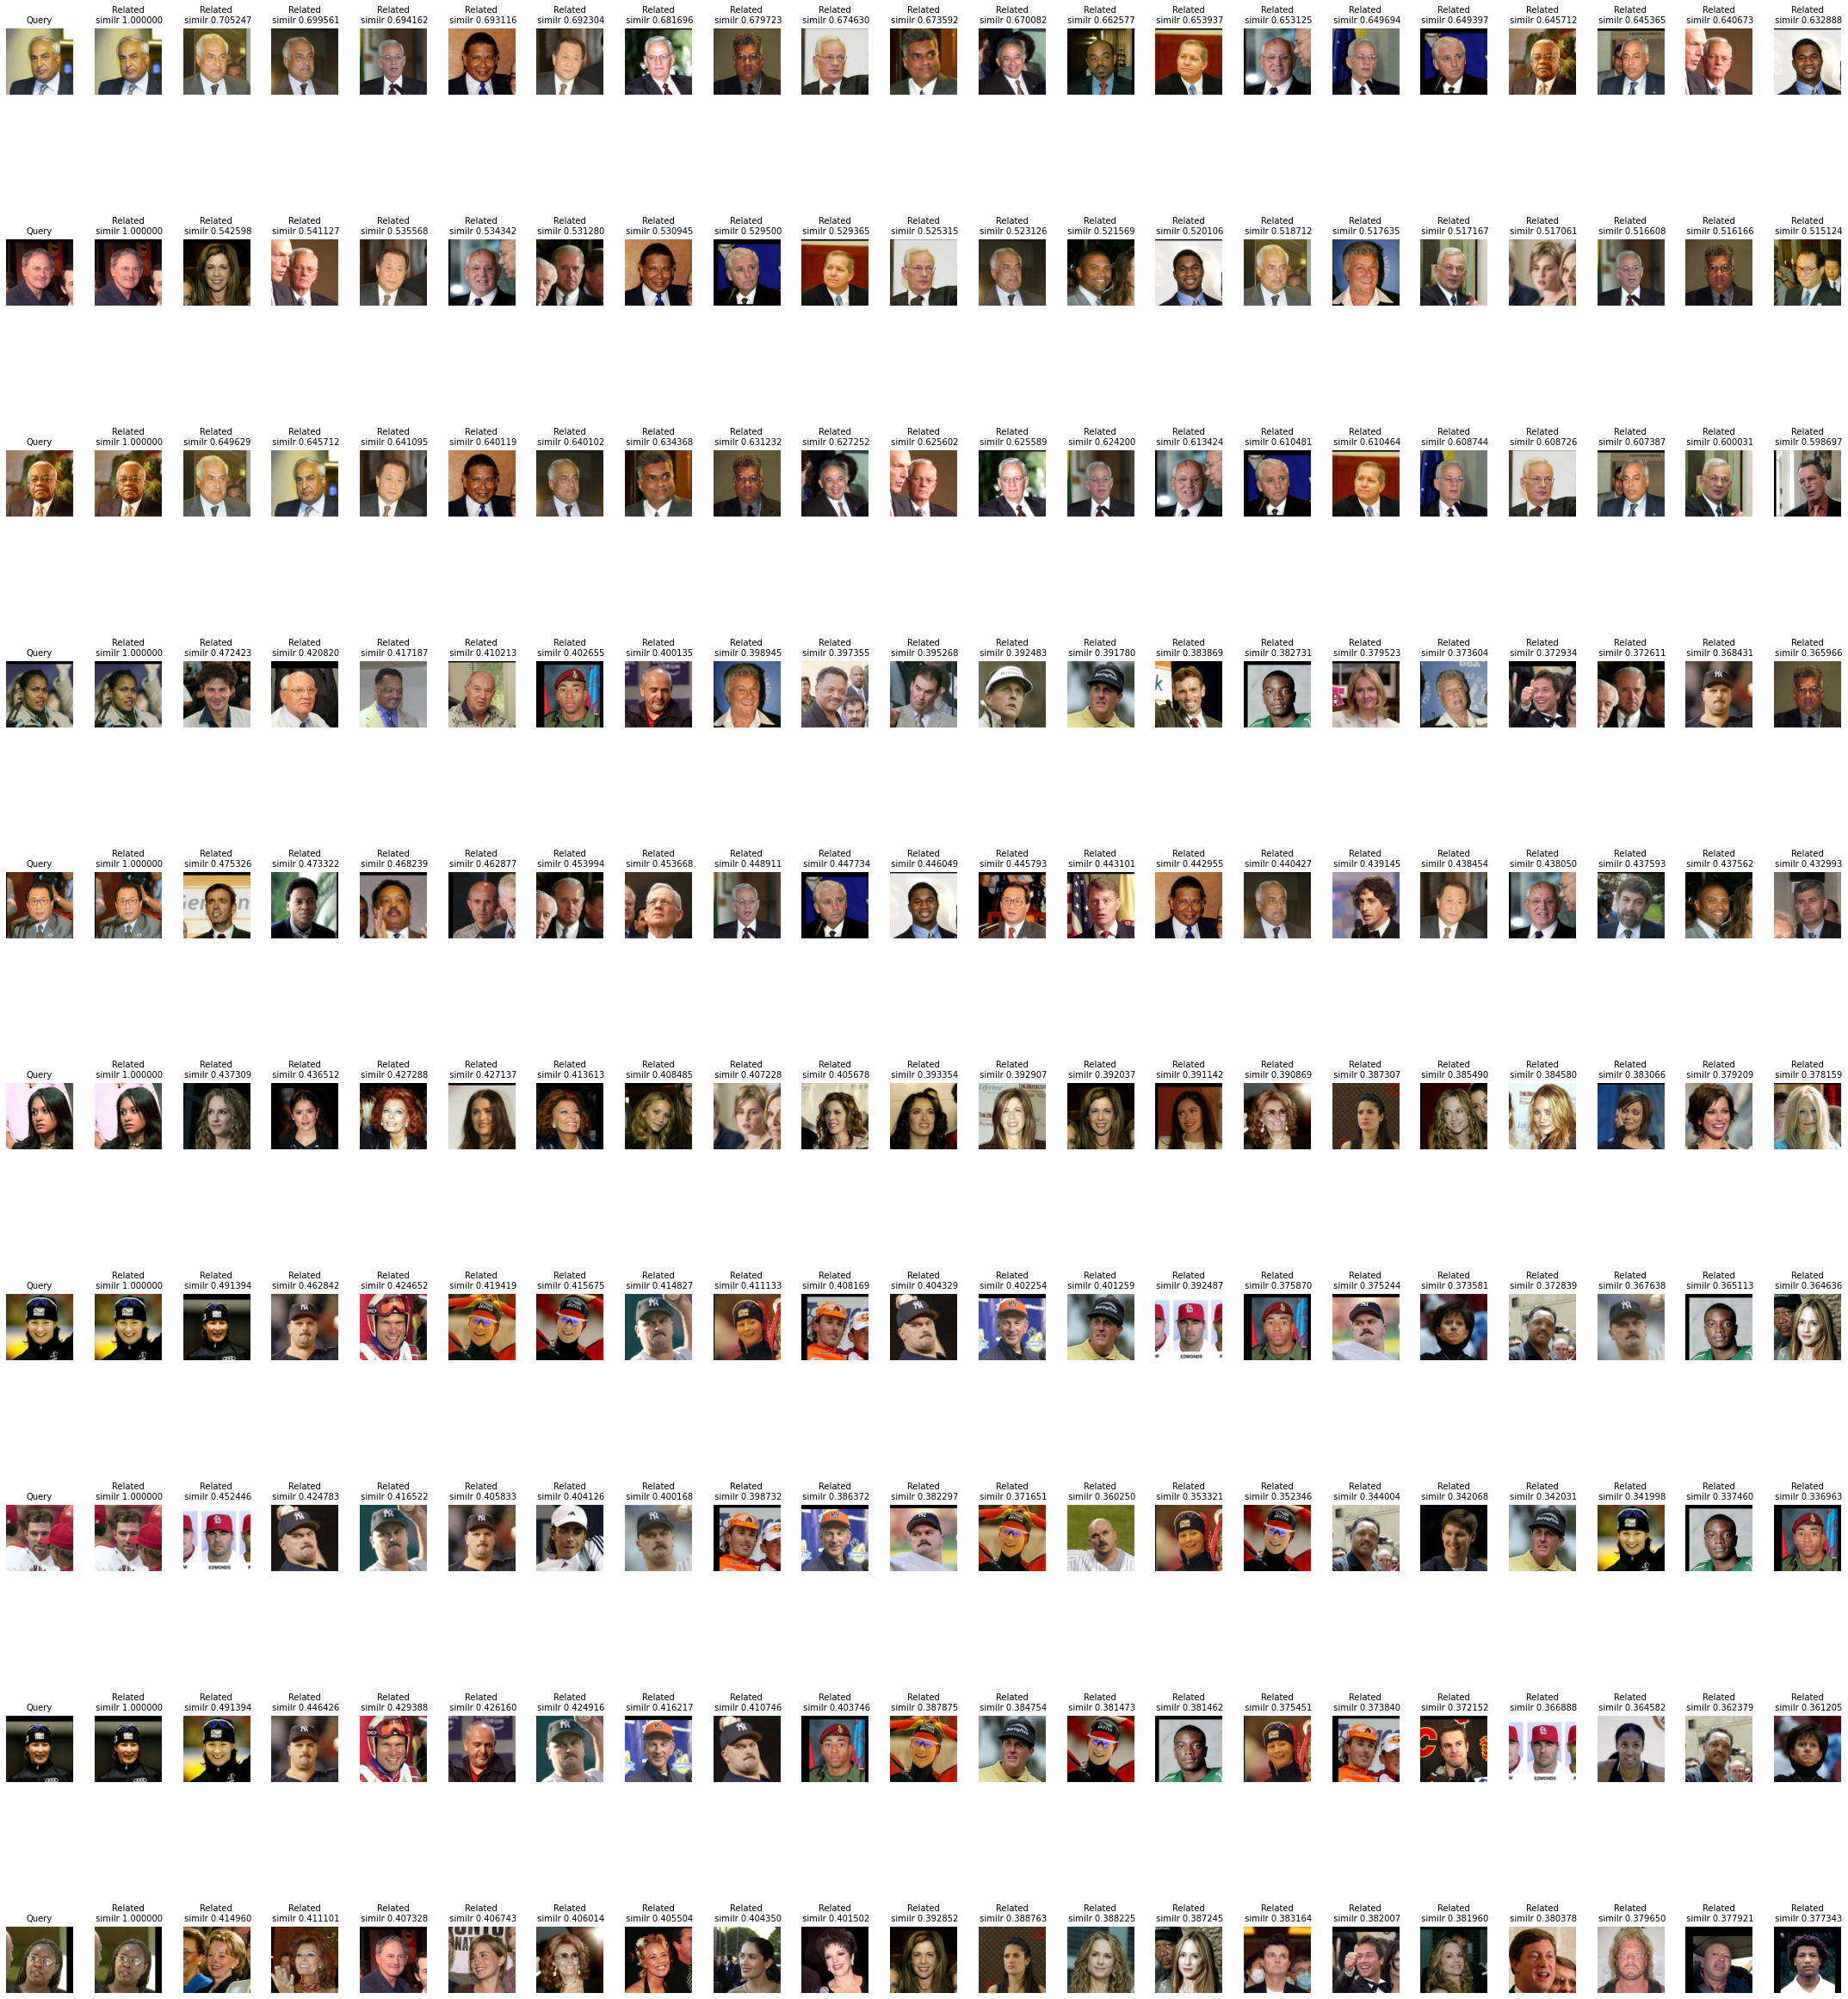

In [ ]:
import sys
from random import shuffle
import matplotlib.pyplot as plt
from scipy import spatial


def visualize_similar_images(img_paths, max_query_imgs=10, max_matches=20):
    img_paths = img_paths[:min(max_query_imgs, len(img_paths))]
    fig, axs = plt.subplots(len(img_paths), max_matches + 1, figsize=(30, 35))

    for i in tqdm(range(len(img_paths))):
        img_path = img_paths[i]
        similar = similar_images_paths(img_path, max_imgs=max_matches)

        __plot_similarities__(axs[i], img_path, similar)

    plt.tight_layout(h_pad=2)
    plt.show()


def __plot_similarities__(ax, img_path, similar):
    ax[0].set_title('Query', size=10)
    ax[0].imshow(img_to_array(load_img(img_path)) / 255)
    ax[0].axis('off')
    ax[0].autoscale()

    cnt = 1
    for path, similarity in similar:
        ax[cnt].imshow(img_to_array(load_img(path)) / 255)
        ax[cnt].set_title('Related\n similr %f' % (similarity,), size=10)
        ax[cnt].axis('off')
        ax[cnt].autoscale()
        cnt += 1


def similar_images_paths(img_path, max_imgs=4):
    query_features = extract_features(img_path)
    stored_features = get_stored_features()

    max_imgs = min(max_imgs, len(stored_features[0]))
    similarities = []

    for filename, encoding in list(zip(*stored_features)):
        h_distance = spatial.distance.hamming(query_features, encoding)
        c_distance = spatial.distance.cosine(query_features, encoding)
        similarity = 1 - (h_distance + c_distance) / 2
        similarities.append((filename, similarity))

    similarities.sort(key=lambda tup: -tup[1])
    return similarities[:max_imgs]


if __name__ == "__main__":
    
        paths = get_file_list(images_folder_path)
        shuffle(paths)
        visualize_similar_images(paths)

# Part 2
Restart Jupyter kernel

In [ ]:
! pip install --upgrade elastiknn-client

In [ ]:
from elastiknn import models
from IPython.core.display import Image
import elastiknn
from elastiknn.client import ElastiknnClient
from elastiknn.utils import ndarray_to_dense_float_vectors
from elastiknn.api import Vec, NearestNeighborsQuery
import elasticsearch
import numpy as np
import pickle

es = elasticsearch.Elasticsearch("http://67.202.45.16:9200", http_auth=('elastic','cs370g12elastic'))
client = ElastiknnClient(es)

In [ ]:
with open("/content/filenames.pickle", 'rb') as filefd:
    with open("/content/features.pickle", 'rb') as featuresfd:
        file_list = pickle.load(filefd)
        features = pickle.load(featuresfd)

In [ ]:
knn_model = models.ElastiknnModel(algorithm="exact", metric="cosine", es=es)
knn_model.fit(np.array(features))

index was not given, using elastiknn-1651018104 instead


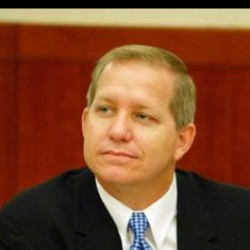

Query Image: 1


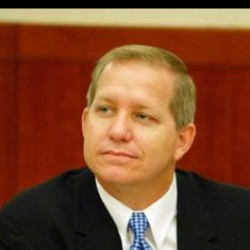

Image: 1 
Similarity: 1.0


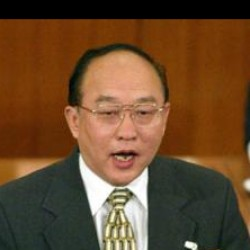

Image: 239 
Similarity: 0.9196556


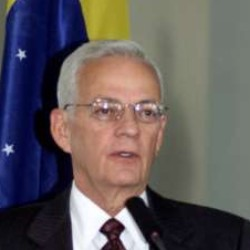

Image: 174 
Similarity: 0.9177188000000001


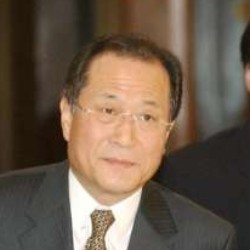

Image: 92 
Similarity: 0.9160326999999999


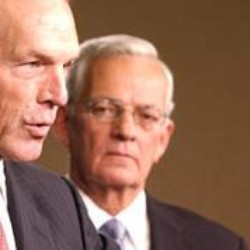

Image: 171 
Similarity: 0.9052309999999999


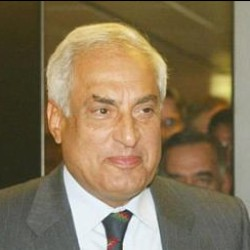

Image: 6 
Similarity: 0.901219


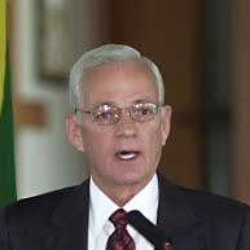

Image: 176 
Similarity: 0.9005129999999999


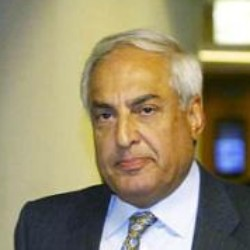

Image: 5 
Similarity: 0.8996717000000001


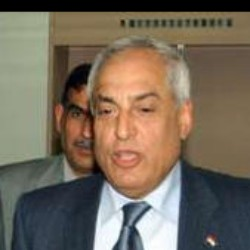

Image: 8 
Similarity: 0.8991513


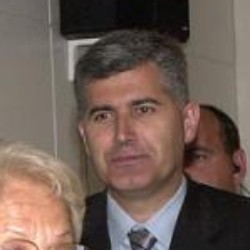

Image: 42 
Similarity: 0.8966193


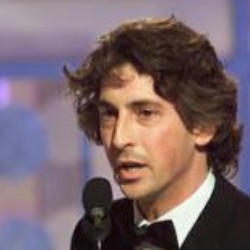

Query Image: 2


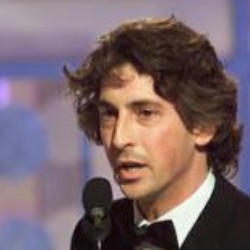

Image: 2 
Similarity: 1.0


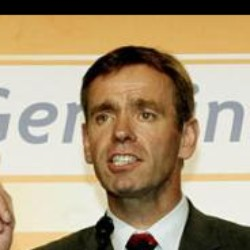

Image: 149 
Similarity: 0.8486507999999999


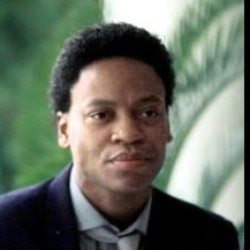

Image: 230 
Similarity: 0.8328319


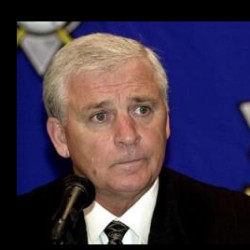

Image: 20 
Similarity: 0.8306826


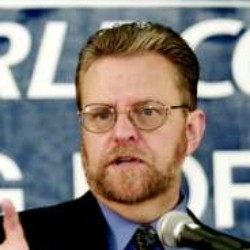

Image: 109 
Similarity: 0.8284575999999999


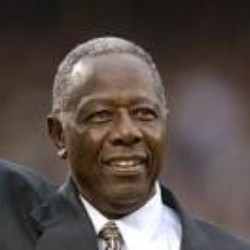

Image: 56 
Similarity: 0.8068249000000001


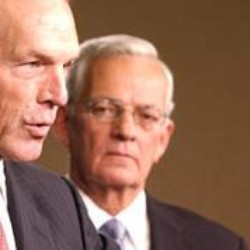

Image: 171 
Similarity: 0.797264


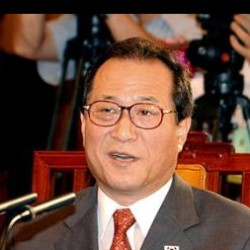

Image: 86 
Similarity: 0.7943845


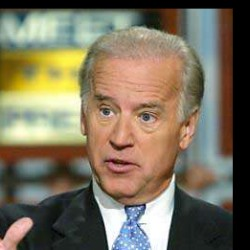

Image: 117 
Similarity: 0.7889485


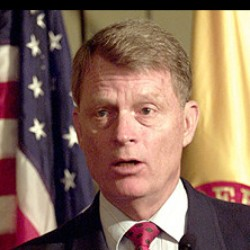

Image: 181 
Similarity: 0.786583


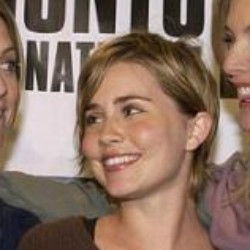

Query Image: 3


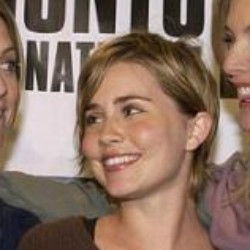

Image: 3 
Similarity: 1.0


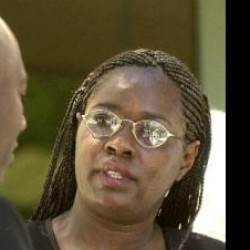

Image: 232 
Similarity: 0.6948334


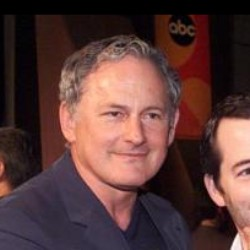

Image: 233 
Similarity: 0.6864436


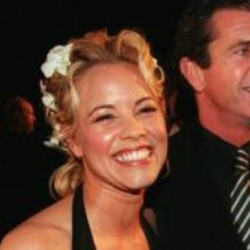

Image: 134 
Similarity: 0.6849916


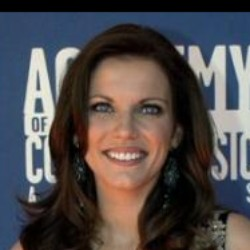

Image: 140 
Similarity: 0.6800241


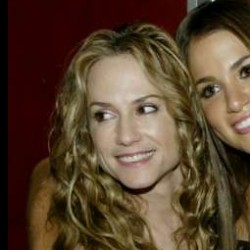

Image: 64 
Similarity: 0.679932


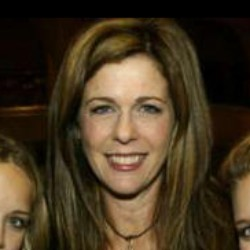

Image: 189 
Similarity: 0.6690343999999999


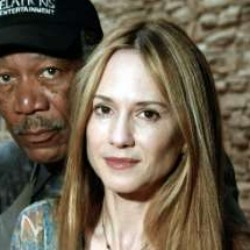

Image: 67 
Similarity: 0.6665483000000001


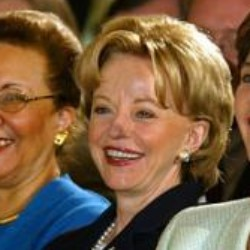

Image: 131 
Similarity: 0.6661383999999999


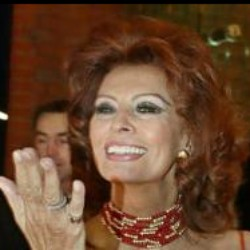

Image: 213 
Similarity: 0.6649316999999999


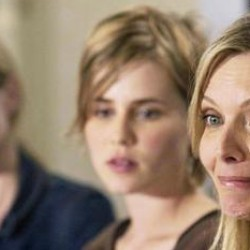

Query Image: 4


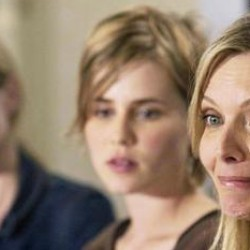

Image: 4 
Similarity: 1.0


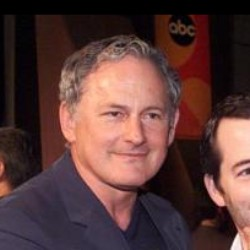

Image: 233 
Similarity: 0.7260173999999999


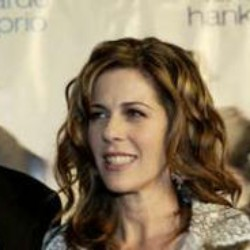

Image: 191 
Similarity: 0.7027080000000001


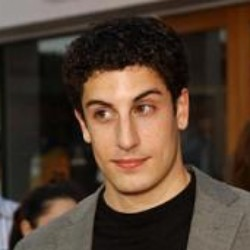

Image: 82 
Similarity: 0.7023306


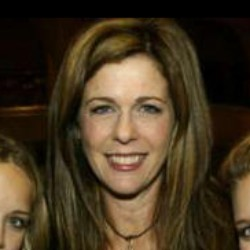

Image: 189 
Similarity: 0.6802954999999999


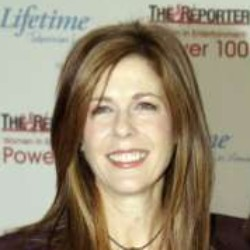

Image: 190 
Similarity: 0.6753085000000001


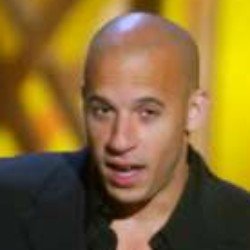

Image: 235 
Similarity: 0.6752184999999999


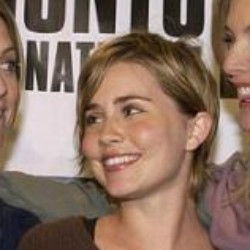

Image: 3 
Similarity: 0.6633842999999999


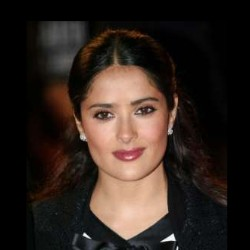

Image: 207 
Similarity: 0.6624973999999999


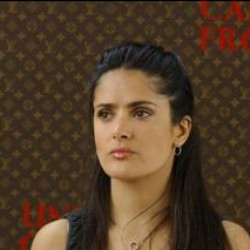

Image: 201 
Similarity: 0.6551541000000001


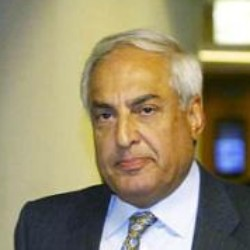

Query Image: 5


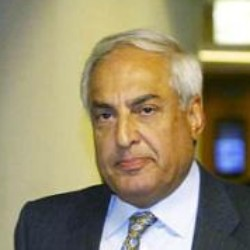

Image: 5 
Similarity: 1.0


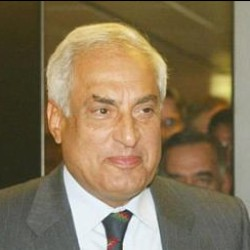

Image: 6 
Similarity: 0.9368612999999999


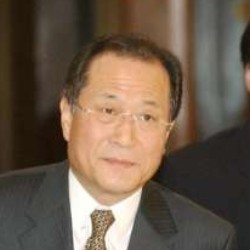

Image: 92 
Similarity: 0.9280645999999999


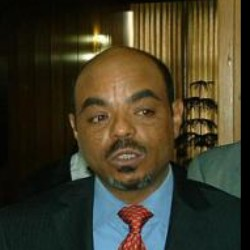

Image: 151 
Similarity: 0.9272047999999999


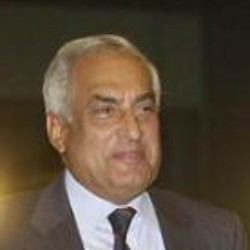

Image: 7 
Similarity: 0.9254894


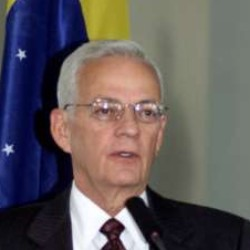

Image: 174 
Similarity: 0.919505


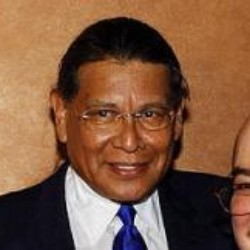

Image: 14 
Similarity: 0.9135754


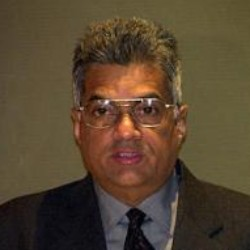

Image: 184 
Similarity: 0.9131571


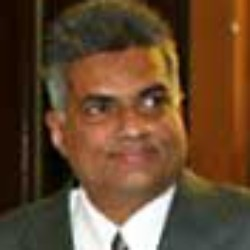

Image: 182 
Similarity: 0.9077299000000001


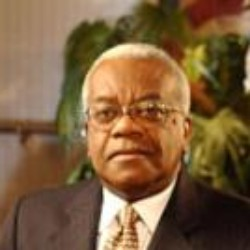

Image: 229 
Similarity: 0.9003104


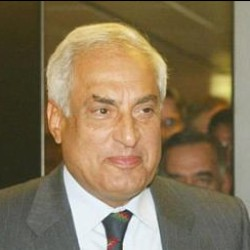

Query Image: 6


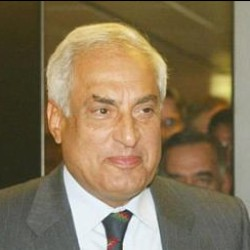

Image: 6 
Similarity: 1.0


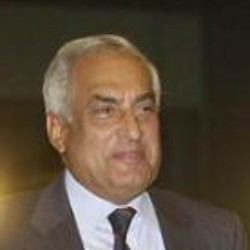

Image: 7 
Similarity: 0.9585173


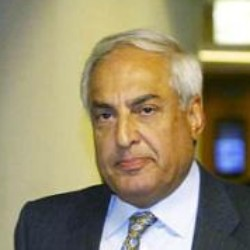

Image: 5 
Similarity: 0.9368612999999999


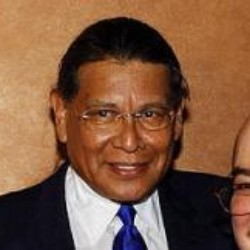

Image: 14 
Similarity: 0.9313723


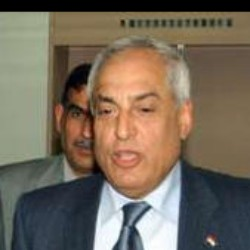

Image: 8 
Similarity: 0.9235237000000001


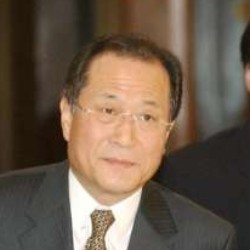

Image: 92 
Similarity: 0.9233218000000001


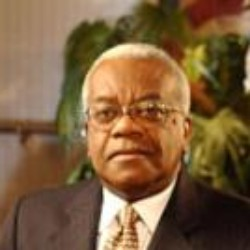

Image: 229 
Similarity: 0.9223052


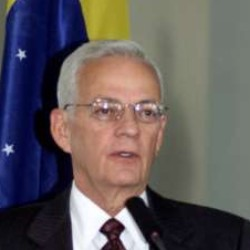

Image: 174 
Similarity: 0.922269


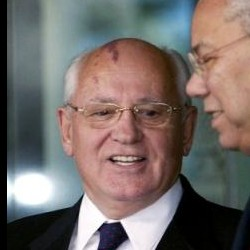

Image: 154 
Similarity: 0.9170693999999999


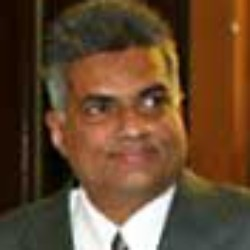

Image: 182 
Similarity: 0.9097251


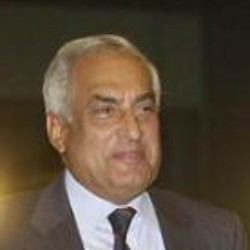

Query Image: 7


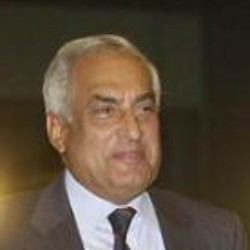

Image: 7 
Similarity: 1.0


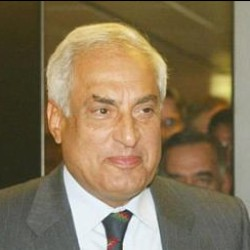

Image: 6 
Similarity: 0.9585173


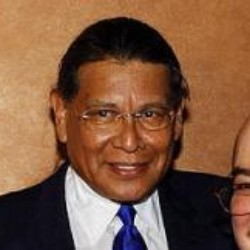

Image: 14 
Similarity: 0.9264475000000001


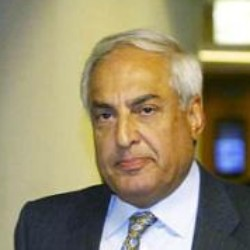

Image: 5 
Similarity: 0.9254894


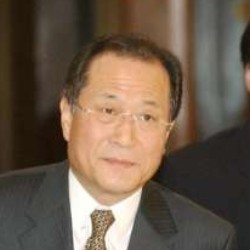

Image: 92 
Similarity: 0.9183209000000001


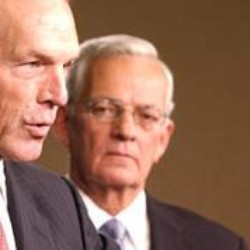

Image: 171 
Similarity: 0.9134367999999999


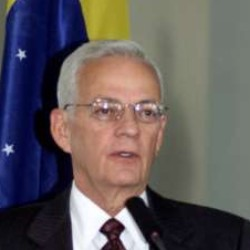

Image: 174 
Similarity: 0.9101478000000001


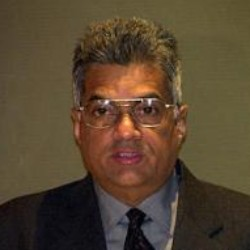

Image: 184 
Similarity: 0.9079216999999999


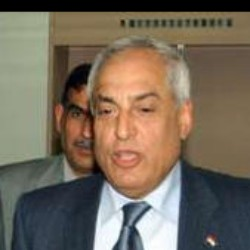

Image: 8 
Similarity: 0.9066671


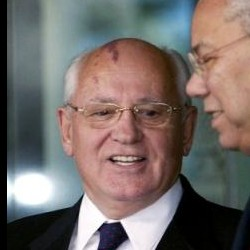

Image: 154 
Similarity: 0.9058626999999999


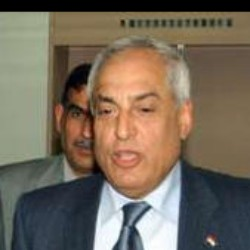

Query Image: 8


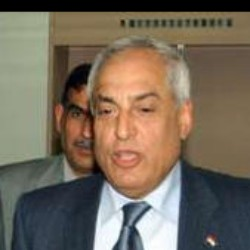

Image: 8 
Similarity: 1.0


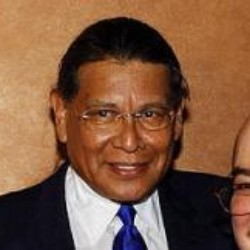

Image: 14 
Similarity: 0.938596


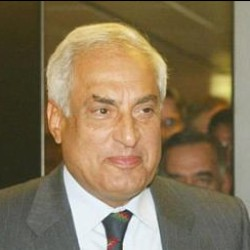

Image: 6 
Similarity: 0.9235237000000001


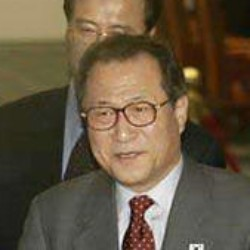

Image: 90 
Similarity: 0.9129003


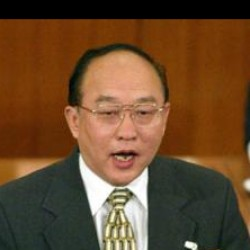

Image: 239 
Similarity: 0.9072808000000001


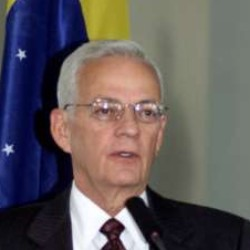

Image: 174 
Similarity: 0.9072678999999999


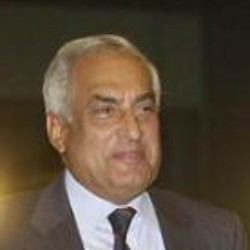

Image: 7 
Similarity: 0.9066671


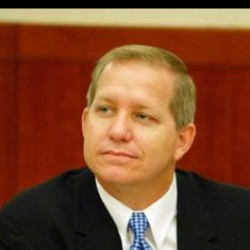

Image: 1 
Similarity: 0.8991513


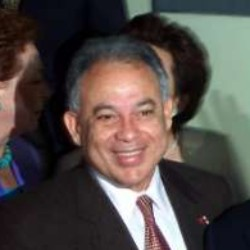

Image: 118 
Similarity: 0.8980699999999999


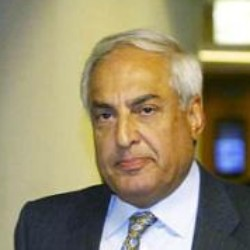

Image: 5 
Similarity: 0.8976637000000001


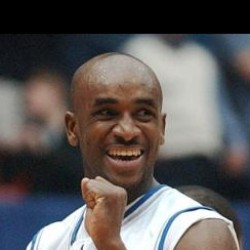

Query Image: 9


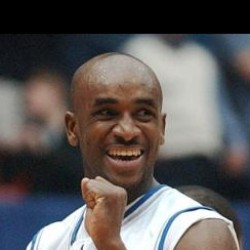

Image: 9 
Similarity: 1.0


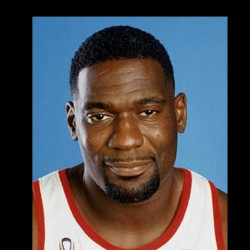

Image: 208 
Similarity: 0.6859774999999999


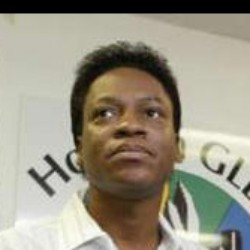

Image: 231 
Similarity: 0.6838850000000001


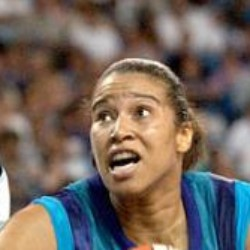

Image: 160 
Similarity: 0.6804941


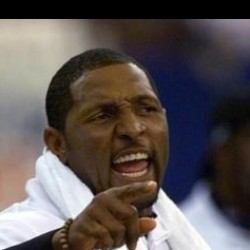

Image: 186 
Similarity: 0.6691186


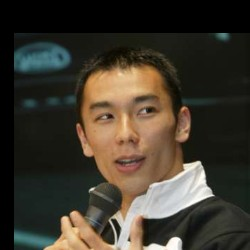

Image: 221 
Similarity: 0.6623905999999999


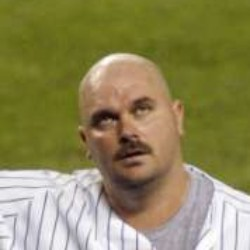

Image: 35 
Similarity: 0.6563064999999999


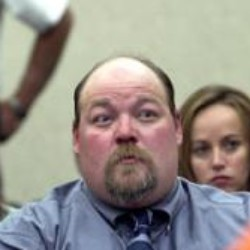

Image: 152 
Similarity: 0.6489670999999999


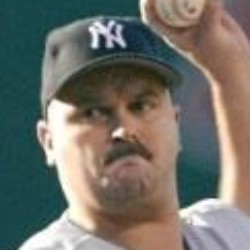

Image: 36 
Similarity: 0.6470199000000001


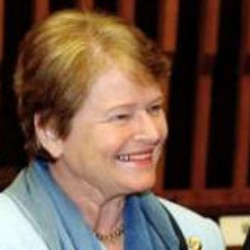

Image: 54 
Similarity: 0.6356200000000001


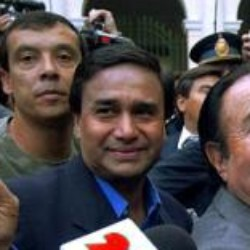

Query Image: 10


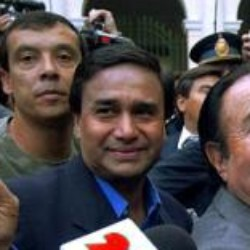

Image: 10 
Similarity: 1.0


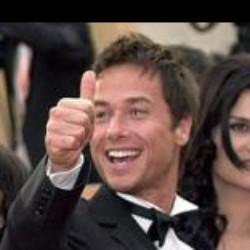

Image: 218 
Similarity: 0.7517480000000001


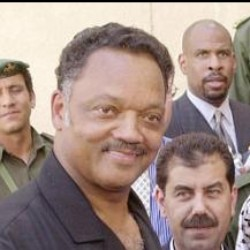

Image: 94 
Similarity: 0.7483575


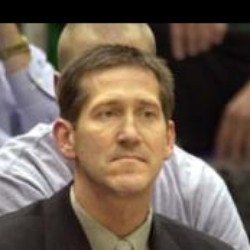

Image: 84 
Similarity: 0.7348064999999999


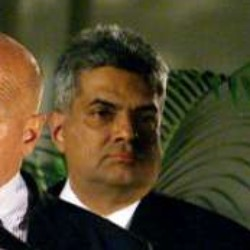

Image: 183 
Similarity: 0.7312695


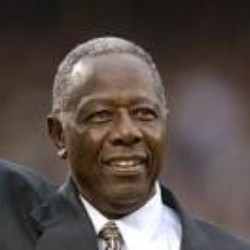

Image: 56 
Similarity: 0.7233357


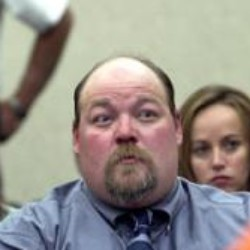

Image: 152 
Similarity: 0.7199850000000001


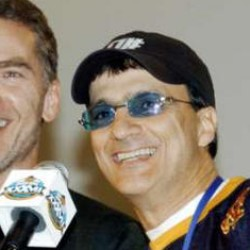

Image: 105 
Similarity: 0.7194444


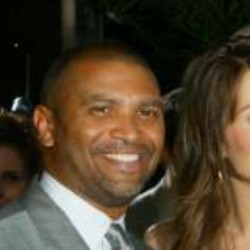

Image: 188 
Similarity: 0.7107703999999999


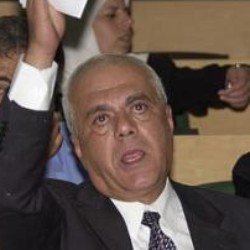

Image: 222 
Similarity: 0.7103349000000001


In [ ]:
for i in range(1,11):    
    query_image_index = i
    num_neighbors = 10

    ret = knn_model.kneighbors([Vec.DenseFloat(values=features[query_image_index].tolist())], n_neighbors=num_neighbors, return_similarity=True)

    display(Image(filename=file_list[query_image_index]))
    print(f"Query Image: {query_image_index}")

    for i in range(len(ret[0][0])):
        display(Image(filename=file_list[ret[0][0][i]]))
        print(f"Image: {ret[0][0][i]} \nSimilarity: {ret[1][0][i] - 1}")